# My first classifier
Identifying and assessing structures in the lung from X-ray scans of the chest is an essential task across multiple diseases involving the lungs and upper abdomen, e.g., lung cancer, infections, pneumonia, broken ribs, and more. X-ray images can provide a detailed view of the lungs and surrounding structures, making it possible to detect, analyze, monitor, and assess treatment response. Computer-aided diagnostic tools addressing chest X-rays are important in medical imaging, possibly increasing speed, accuracy, consistency, and cost-effectiveness. 

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chexpert/train_cheXbert.csv
/kaggle/input/chexpert/valid.csv
/kaggle/input/chexpert/train_visualCheXbert.csv
/kaggle/input/chexpert/train.csv


In [4]:
#basic fastai import
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
# fastai library for working with medical images, also known as DICOM-files
from fastai.medical.imaging import *

#Python package for processing DICOM-files
import pydicom

#used for data analisis and working with datasets
import pandas as pd

**Download and import of the data**

In [5]:
# the variable LUNGE_KIL stores the absolute path for the folder containing the images that I will use to build my classifier
lunge_kil = untar_data(URLs.SIIM_SMALL)

**Preparing and splitting the data**

In [6]:
#loading the paths to the DICOM-files
pic = get_dicom_files(lunge_kil/f"train/")

In [7]:
#splitting the dataset to get a training and a validation set
train,valid = RandomSplitter()(pic)

In [8]:
#cheking that the data has been updated correctly by checking the header, the pixel data and the image that is stored in the path
sample = pic[9].dcmread()

In [9]:
#will print out the function above and will include all the aspect of a DICOM-file 
sample

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6180.1517875196.895756
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6180.1517875196.895756
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [10]:
#just for fun, but also that the pixel-format of the images look ok and the shape of their array
sample.pixel_array, sample.pixel_array.shape

(array([[109,  99,  92, ...,  83,  83,  83],
        [108,  98,  91, ...,  73,  73,  73],
        [108,  98,  91, ...,  65,  65,  65],
        ...,
        [ 41,  38,  35, ...,  39,  43,  46],
        [ 43,  39,  37, ...,  39,  43,  46],
        [ 44,  41,  39, ...,  39,  43,  46]], dtype=uint8),
 (1024, 1024))

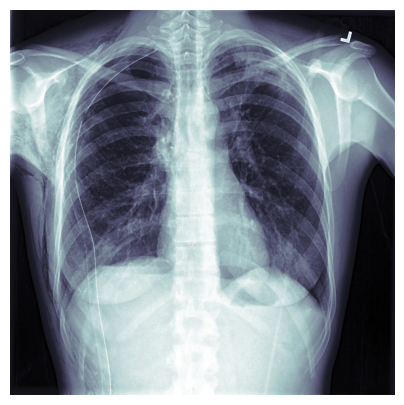

In [11]:
#checking my work. Making sure that I get a desent image and that I have not messed up any of the images with the import or anything so far
sample.show()

In [12]:
#making a dataframe to load the lables for the dataset 
df = pd.read_csv(lunge_kil/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


In [13]:
#making a datablock to prepare the images for training
lunge = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:lunge_kil/f"{x[0]}", 
                   get_y=lambda x:x[1],
                   batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)])
                 
dls = lunge.dataloaders(df.values, num_workers=0)

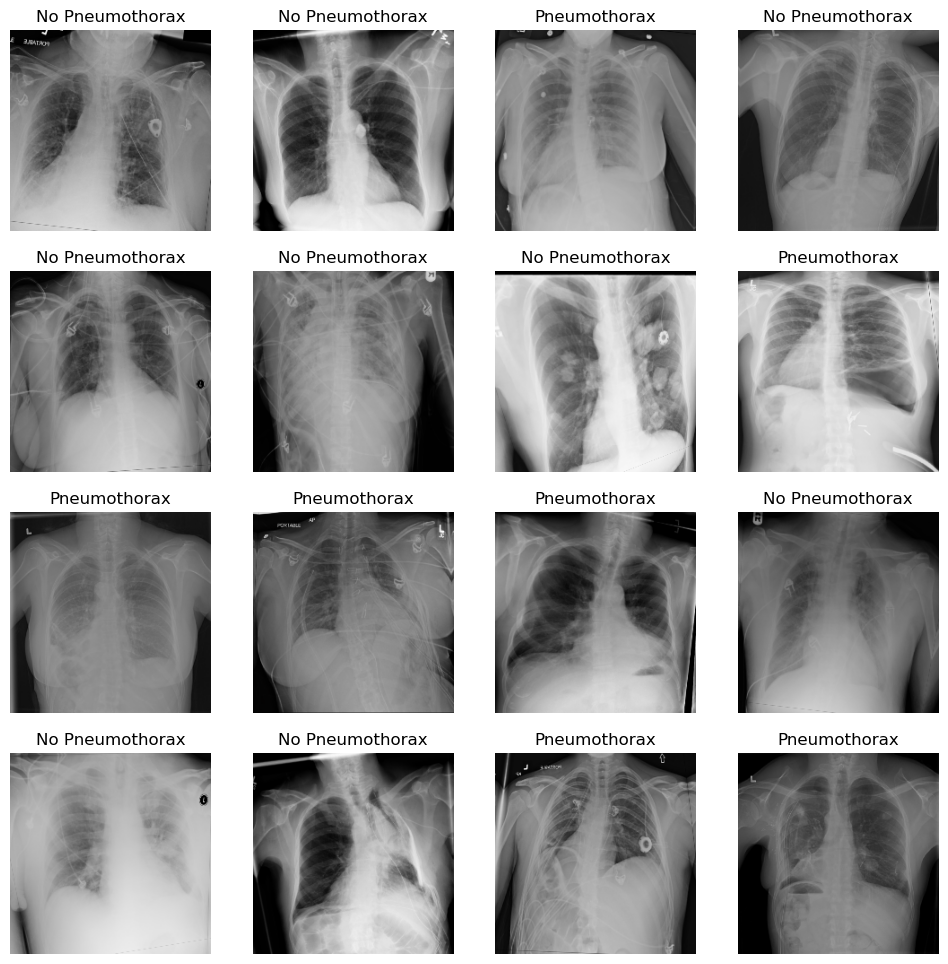

In [14]:
#ploting the first batch just to see what we are dealing with
dls = lunge.dataloaders(df.values)
dls.show_batch(max_n=16)

**Training**

In [15]:
#prepearing the data for the test later, this is an unnecesary step for recreating my model due to the problems I faced with the dataset. The problems are discused in the project report
lung = lunge.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

In [16]:
#initiate the training
learner = vision_learner(dls, resnet18, metrics=accuracy)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
#checking what is the best lost function
learner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [18]:
#checking what is the best optimizer
learner.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

SuggestedLRs(valley=0.0020892962347716093)

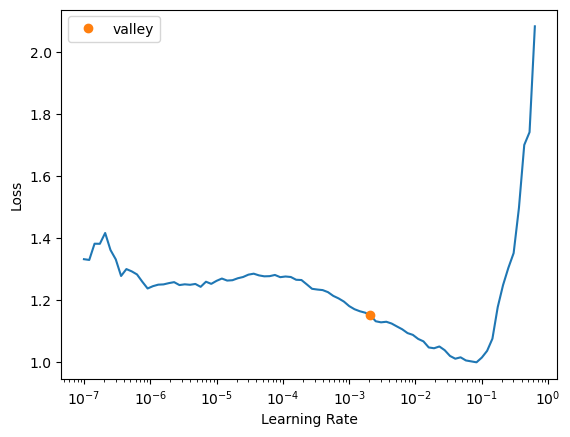

In [19]:
#finding the best learning rate
learner.lr_find()

In [20]:
#from my online research I found out the ideal number of epochs to train the model, was 11 so that is how long I trained it.
learner.fine_tune(11)

epoch,train_loss,valid_loss,accuracy,time
0,1.111528,1.815430,0.320000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.162019,1.516446,0.340000,00:04
1,1.203054,1.231605,0.420000,00:04
2,1.138859,1.128691,0.460000,00:04
3,1.083378,1.175148,0.460000,00:04
4,0.987367,1.010635,0.520000,00:04
5,0.927471,0.892311,0.600000,00:04
6,0.877774,0.923366,0.620000,00:04
7,0.825007,0.926385,0.620000,00:04
8,0.795236,0.946899,0.600000,00:04
9,0.757885,0.984632,0.580000,00:04


In [21]:
#make a prediction on an image 
learner.predict(lunge_kil/f"train/Pneumothorax/000003.dcm")

('Pneumothorax', tensor(1), tensor([0.1571, 0.8429]))

In [22]:
tta = learner.tta(use_max=True)

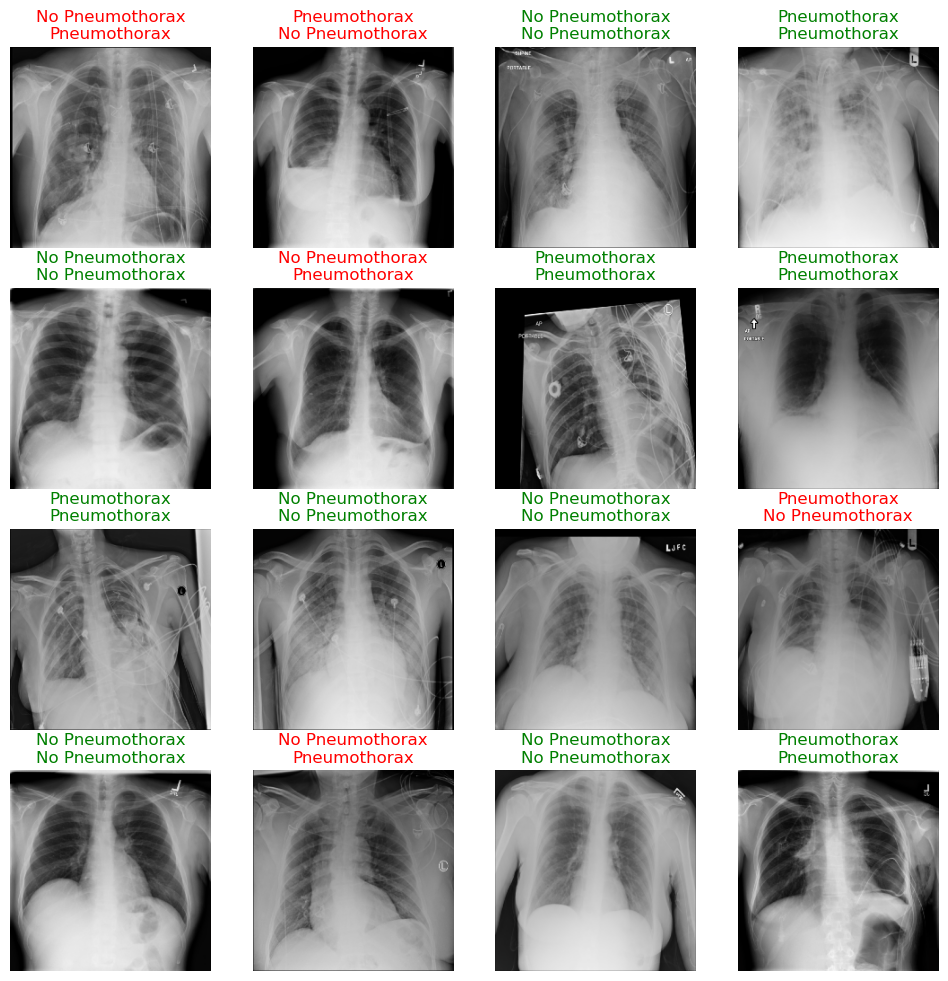

In [23]:
learner.show_results(max_n=16)

In [24]:
inter = Interpretation.from_learner(learner)

In [25]:
inte = inter.top_losses(2)

**Evaluation of result**

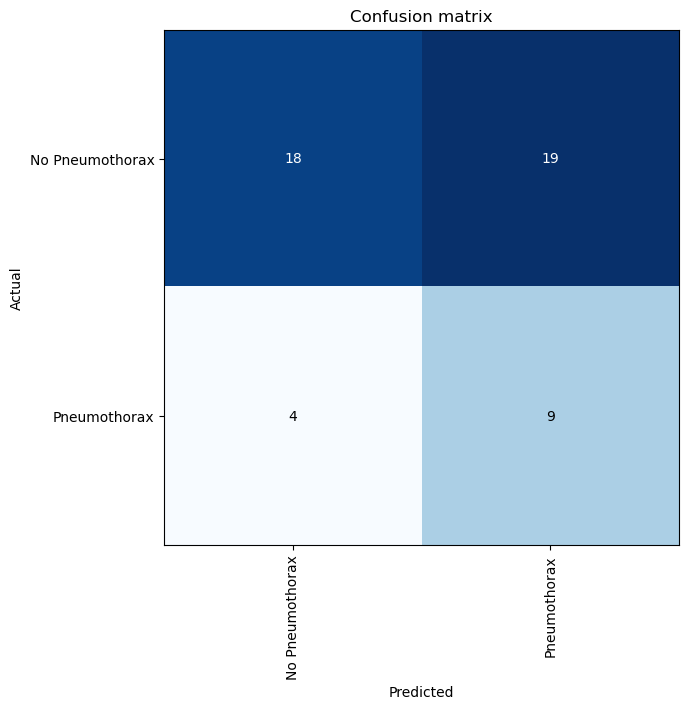

In [26]:
#making a confusion matrix against the valid dataset, to see how it did
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [27]:
#convert the matrix into simple number to get some more reason out of the numbers in the confusion matrix
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

18 19 4 9


In [28]:
#the model says that the patient has a disease, when it is not the case. It wants to quantify the avoidance of false negatives
sensitivity = tp/(tp + fn)
sensitivity

0.6923076923076923

In [29]:
#the model says that the patient has not the disease and it acctually has the disease. Wants to avoid false positives.
specificity = tn/(fp + tn)
specificity

0.4864864864864865

In [30]:
#the model says that the paitent has the disase, the procentage given here is the likelyhood of it being true
ppv = tp/(tp+fp)
ppv

0.32142857142857145

In [31]:
#the model says that the paitent does not have the disase, the procentage given this is true
npv = tn/(tn+fn)
npv

0.8181818181818182

In [32]:
#was told by the articles that this in order to calculate the accuracy of my model
val = len(dls.valid_ds)
prevalence = 14/val 
prevalence

0.28

In [33]:
#The overal accurct to the model
accuracy = (sensitivity * prevalence) + (specificity * (1 - prevalence))
accuracy

0.5441164241164241

# the big test (or so I tought)
Please use common sence when using the next lines of code. Idealy do not use it at all... For further argumentation for why this is the case, please read my project report

In [34]:
#will be used for the "big test" of the whole dataset
chexpert = pd.read_csv('/kaggle/input/chexpert/train_visualCheXbert.csv')

In [35]:
obs = len(chexpert)
print('The number of observations in x-rays : ', obs)

chexpert.head(5)

The number of observations in x-rays :  223414


,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CheXpert-v1.0/train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,CheXpert-v1.0/train/patient00002/study1/view2_lateral.jpg,Female,83,Lateral,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,CheXpert-v1.0/train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#cleaning and exploring the chexpert dataset
#dropping the lateral views, because i only want to focus on the frontal due to the simplisty of finding observations and clasifing them in the frontal view.
chexpert = chexpert[chexpert['Frontal/Lateral'] == 'Frontal']


chexpert.head(5)

,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CheXpert-v1.0/train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,CheXpert-v1.0/train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CheXpert-v1.0/train/patient00004/study1/view1_frontal.jpg,Female,20,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
chexpert = chexpert.drop("AP/PA", axis=1)
chexpert.head(5)

,Path,Sex,Age,Frontal/Lateral,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CheXpert-v1.0/train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,CheXpert-v1.0/train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CheXpert-v1.0/train/patient00004/study1/view1_frontal.jpg,Female,20,Frontal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
learner.predict(chexpert/f"CheXpert-v1.0/train/patient00002/study1/view1_frontal.jpg")

TypeError: unsupported operand type(s) for /: 'str' and 'str'

# Credits
used for inspo in how to make medical imaging models
https://docs.fast.ai/tutorial.medical_imaging.html

